# London Properties Analysis

This notebook analyzes London property data to identify pricing trends, property type distributions, and regional differences.

## 1. Setup and Imports



In [67]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.ticker as ticker

# Set visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams.update({'font.size': 12})  # Increase font size for readability

%matplotlib inline



## 2. Helper Functions



In [68]:
# Create a pound formatter for axes
def pound_formatter(x, pos):
    if x >= 1000000:
        return f'£{x/1000000:.1f}M'
    elif x >= 1000:
        return f'£{x/1000:.0f}K'
    else:
        return f'£{x:.0f}'



## 3. Data Loading and Initial Configuration



In [69]:
# Define file paths 
file_path = "C:/temp/london_properties.csv" 
cleaned_file_path = "C:/temp/london_properties_cleaned.csv" 
analyzed_file_path = "C:/temp/london_properties_analyzed.csv"

# Load the dataset 
df = pd.read_csv(file_path) 



## 4. Data Cleaning



In [70]:
# Convert specific columns to Title Case (First letter capitalized) 
columns_to_capitalize = ["town_city", "district", "county", "street"] 
df[columns_to_capitalize] = df[columns_to_capitalize].apply(lambda x: x.str.title()) 

# Map property types to their full names
property_type_mapping = {
    'D': 'Detached',
    'S': 'Semi-Detached',
    'T': 'Terraced',
    'F': 'Flat/Apartment',
    'O': 'Other'
}

# Replace property type codes with full names
df['property_type'] = df['property_type'].map(property_type_mapping)

# Save the cleaned file with updated property types
df.to_csv(cleaned_file_path, index=False) 



## 5. Preliminary Data Exploration



In [71]:
# Display the first few rows
print(f"✅ Cleaned data saved at: {cleaned_file_path}") 
print(df.head())

# Format price statistics for better readability
price_stats = df['price'].describe()
print("\nPrice Statistics:")
print(price_stats)

# Create a formatted version of the statistics
print("\nPrice Statistics (Formatted):")
print(f"Count: {price_stats['count']:,.0f} properties")
print(f"Mean: £{price_stats['mean']:,.2f}")
print(f"Standard Deviation: £{price_stats['std']:,.2f}")
print(f"Minimum: £{price_stats['min']:,.2f}")
print(f"25th Percentile: £{price_stats['25%']:,.2f}")
print(f"Median: £{price_stats['50%']:,.2f}")
print(f"75th Percentile: £{price_stats['75%']:,.2f}")
print(f"Maximum: £{price_stats['max']:,.2f}")

# Additional price statistics
print("\nAdditional Price Analysis:")
print(f"Price Range: £{df['price'].min():,} to £{df['price'].max():,}")
print(f"Median Price: £{df['price'].median():,}")
print(f"Price Variance: {df['price'].var():,.2f}")
print(f"Number of properties above £1M: {(df['price'] > 1000000).sum()}")

# Basic data exploration
print("Dataset Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())

# Property type distribution
print("\nProperty Type Distribution:")
print(df['property_type'].value_counts())


✅ Cleaned data saved at: C:/temp/london_properties_cleaned.csv
                           transaction_id    price date_of_transfer  postcode  \
0  {25E9DA81-5147-555E-E063-4704A8C066F2}   367500       2024-05-17  SE25 6QA   
1  {25E9DA81-5150-555E-E063-4704A8C066F2}   987000       2024-09-26  SW14 8DR   
2  {25E9DA81-5151-555E-E063-4704A8C066F2}  1080600       2024-09-13  SE22 8QR   
3  {25E9DA81-5152-555E-E063-4704A8C066F2}  2098000       2024-10-14  SW15 1AE   
4  {25E9DA81-5153-555E-E063-4704A8C066F2}  1580000       2024-09-03   SW4 9JP   

   property_type old_new duration paon              street town_city  \
0  Semi-Detached       N        F  118        Clifton Road    London   
1       Terraced       N        F   31          Lewin Road    London   
2       Terraced       N        F   21  Playfield Crescent    London   
3  Semi-Detached       N        F   42     Clarendon Drive    London   
4  Semi-Detached       N        F   35     Narbonne Avenue    London   

               di


## 6. Identifying and Handling Outliers



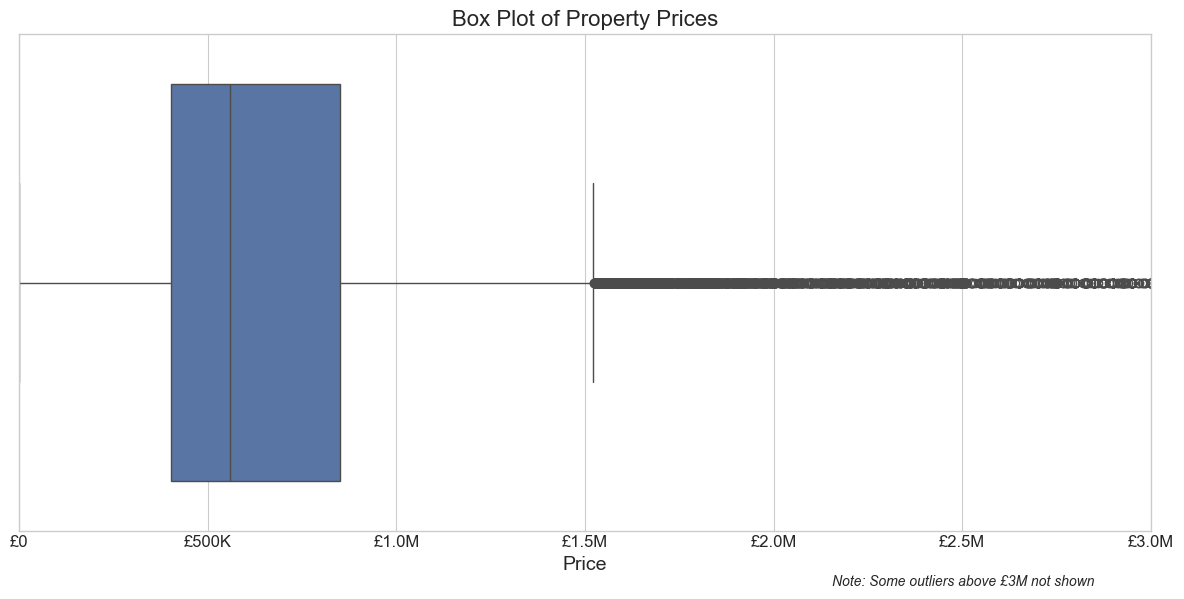


Potentially Suspicious Price Records:
         price   property_type  postcode town_city                district
857   10300000        Terraced   W11 2JJ    London  Kensington And Chelsea
1527      5000           Other    E6 1AD    London                  Newham
1650  16500000   Semi-Detached   W11 3NS    London  Kensington And Chelsea
1752  15000000           Other   SE8 5JE    London                Lewisham
1833  28000000  Flat/Apartment  SW1X 8HG    London  Kensington And Chelsea
1846  10934543           Other  SE18 6BU    London               Greenwich
1877  11250000  Flat/Apartment    N2 0BG    London                  Barnet
3234      1600           Other  SE15 3PT    London               Southwark
3248  20000000           Other  WC1V 7AA    London                  Camden
3368  16500000           Other   N20 8PE    London                  Barnet

Before cleaning: 44869 records
After removing price outliers: 44584 records


In [72]:
# Visual investigation of outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['price'])
plt.title('Box Plot of Property Prices', fontsize=16)
plt.xlabel('Price', fontsize=14)
ax = plt.gca()
formatter = ticker.FuncFormatter(pound_formatter)
ax.xaxis.set_major_formatter(formatter)
plt.xlim(0, 3000000)  # Limit x-axis to £3M
plt.figtext(0.7, 0.01, "Note: Some outliers above £3M not shown", fontsize=10, style='italic')
plt.tight_layout()
plt.savefig('C:/temp/price_boxplot.png', dpi=300)
plt.show()
plt.close()

# Investigate extremely low and high prices
low_price_threshold = 10000  # £10,000 seems very low for London
high_price_threshold = 10000000  # £10M+

suspicious_properties = df[(df['price'] < low_price_threshold) | (df['price'] > high_price_threshold)]
print("\nPotentially Suspicious Price Records:")
print(suspicious_properties[['price', 'property_type', 'postcode', 'town_city', 'district']].head(10))

# Create a clean version for analysis
df_clean = df.copy()

# Handle extreme outliers
print(f"\nBefore cleaning: {len(df_clean)} records")
df_clean = df_clean[(df_clean['price'] >= low_price_threshold) & (df_clean['price'] <= high_price_threshold)]
print(f"After removing price outliers: {len(df_clean)} records")



## 7. Feature Engineering



In [73]:
# Convert date column to datetime
df_clean['date_of_transfer'] = pd.to_datetime(df_clean['date_of_transfer'])

# Create additional features for analysis
df_clean['year'] = df_clean['date_of_transfer'].dt.year
df_clean['month'] = df_clean['date_of_transfer'].dt.month
df_clean['quarter'] = df_clean['date_of_transfer'].dt.quarter
df_clean['month_name'] = df_clean['date_of_transfer'].dt.strftime('%b')

# Create property price bands
price_bins = [0, 250000, 500000, 750000, 1000000, 2000000, 5000000, float('inf')]
price_labels = ['Under £250K', '£250K-£500K', '£500K-£750K', '£750K-£1M', '£1M-£2M', '£2M-£5M', 'Over £5M']
df_clean['price_band'] = pd.cut(df_clean['price'], bins=price_bins, labels=price_labels)

# Save the cleaned dataset
df_clean.to_csv(analyzed_file_path, index=False)
print(f"\nCleaned data saved with {len(df_clean)} records")



Cleaned data saved with 44584 records



## 8. Visualization 1: Price Distribution Analysis



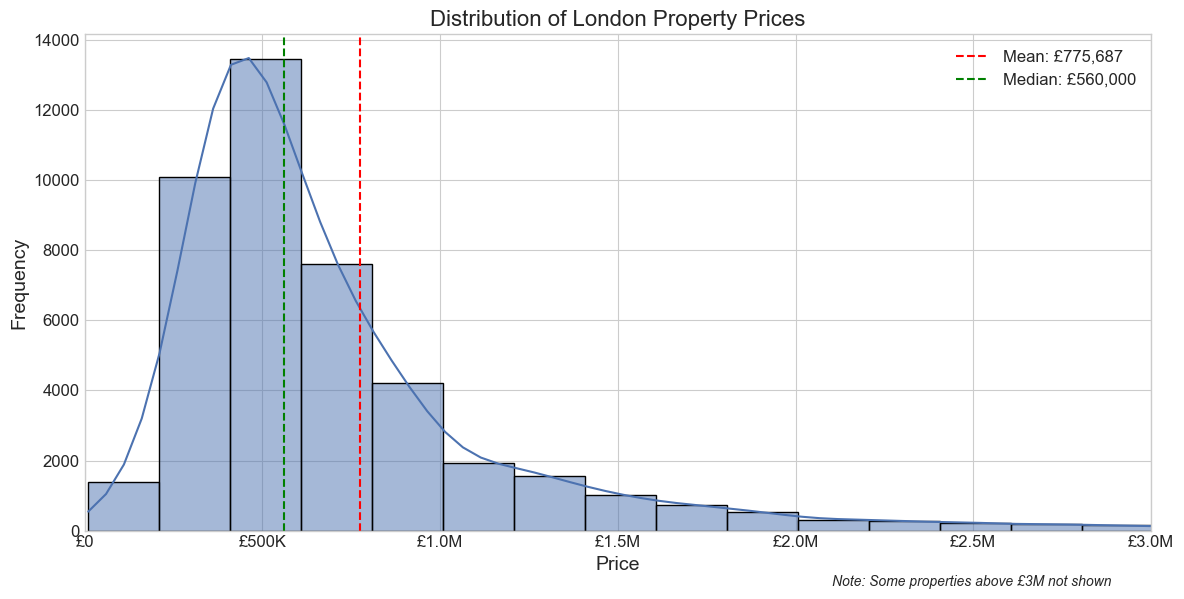

In [74]:
plt.figure(figsize=(12, 6))
sns.histplot(df_clean['price'], bins=50, kde=True)
plt.title('Distribution of London Property Prices', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.axvline(df_clean['price'].mean(), color='red', linestyle='--', 
            label=f'Mean: £{df_clean["price"].mean():,.0f}')
plt.axvline(df_clean['price'].median(), color='green', linestyle='--', 
            label=f'Median: £{df_clean["price"].median():,.0f}')
ax = plt.gca()
ax.xaxis.set_major_formatter(formatter)
plt.xlim(0, 3000000)  # Limit x-axis to £3M for better visibility
plt.figtext(0.7, 0.01, "Note: Some properties above £3M not shown", fontsize=10, style='italic')
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('C:/temp/price_distribution.png', dpi=300)
plt.show()
plt.close()



## 9. Visualization 2: Property Types Analysis



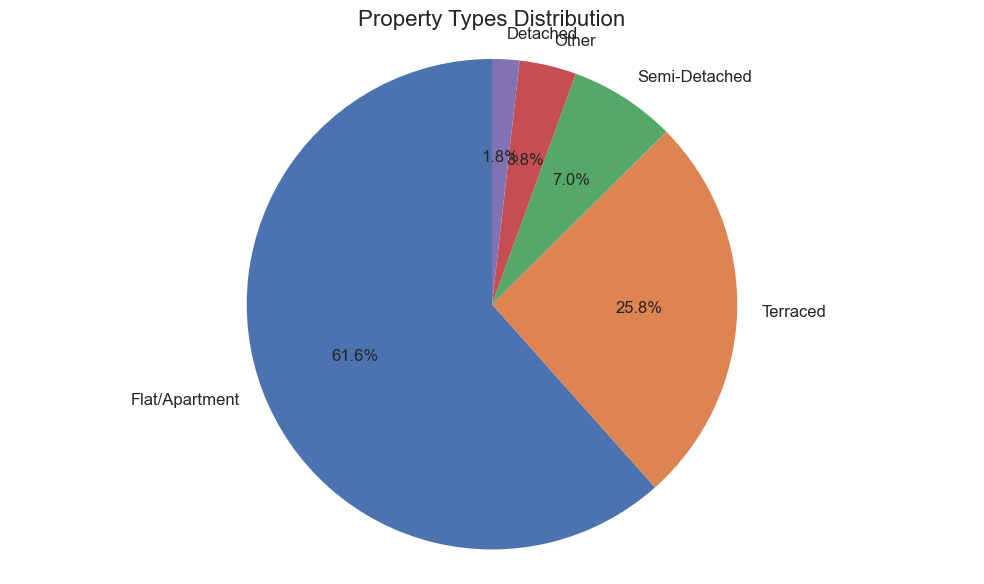

In [75]:
plt.figure(figsize=(10, 6))
property_counts = df_clean['property_type'].value_counts()
plt.pie(property_counts, labels=property_counts.index, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
plt.title('Property Types Distribution', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.savefig('C:/temp/property_types.png', dpi=300)
plt.show()
plt.close()



## 10. Visualization 3: Price by District (Top 15)



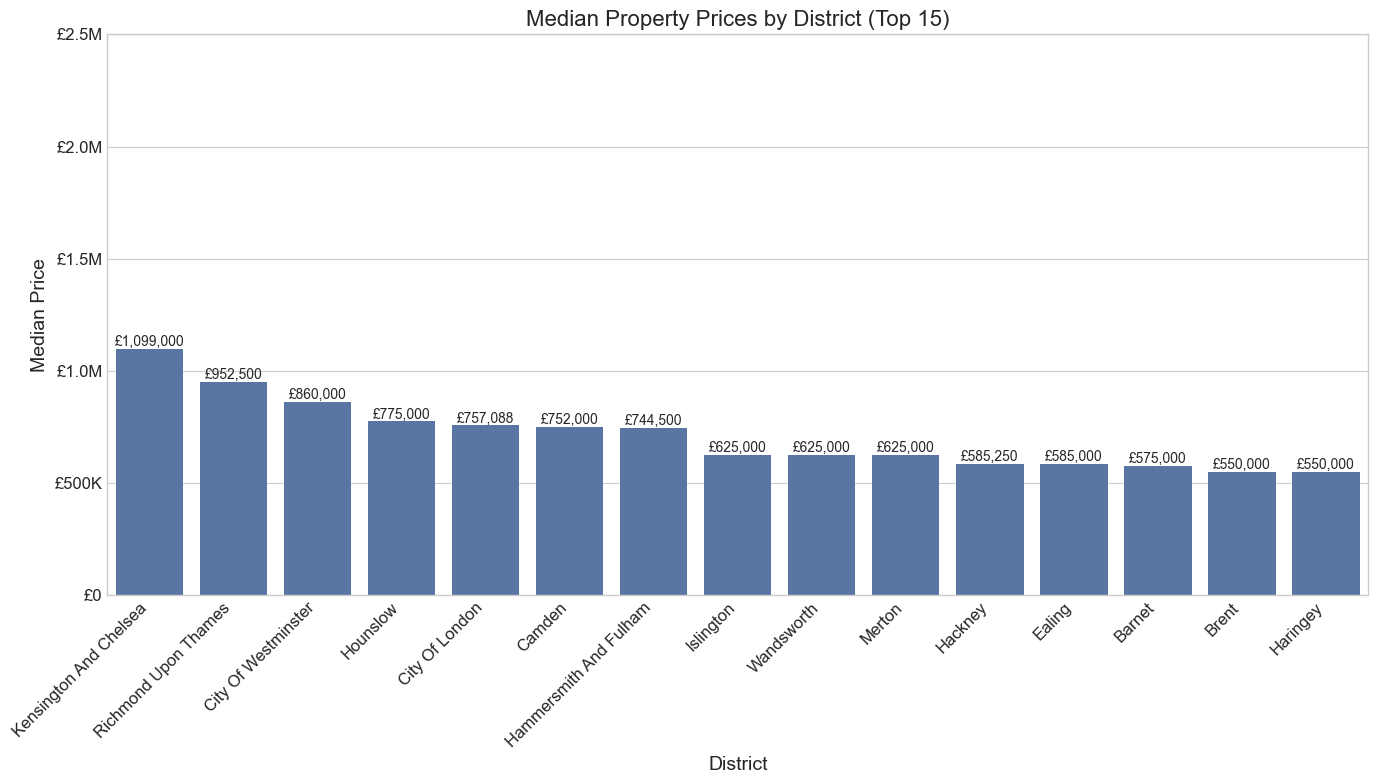

In [76]:
district_prices = df_clean.groupby('district')['price'].agg(['mean', 'median', 'count'])
district_prices = district_prices.sort_values('median', ascending=False).head(15)

plt.figure(figsize=(14, 8))
ax = sns.barplot(x=district_prices.index, y=district_prices['median'])
plt.title('Median Property Prices by District (Top 15)', fontsize=16)
plt.xlabel('District', fontsize=14)
plt.ylabel('Median Price', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
ax.yaxis.set_major_formatter(formatter)
plt.ylim(0, 2500000)  # Limit y-axis to £2.5M for better readability

# Add price labels on top of bars
for i, p in enumerate(ax.patches):
    ax.annotate(f'£{district_prices["median"].iloc[i]:,.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom', fontsize=10)

plt.tight_layout()
plt.savefig('C:/temp/prices_by_district.png', dpi=300)
plt.show()
plt.close()



## 11. Visualization 4: Time Series Analysis



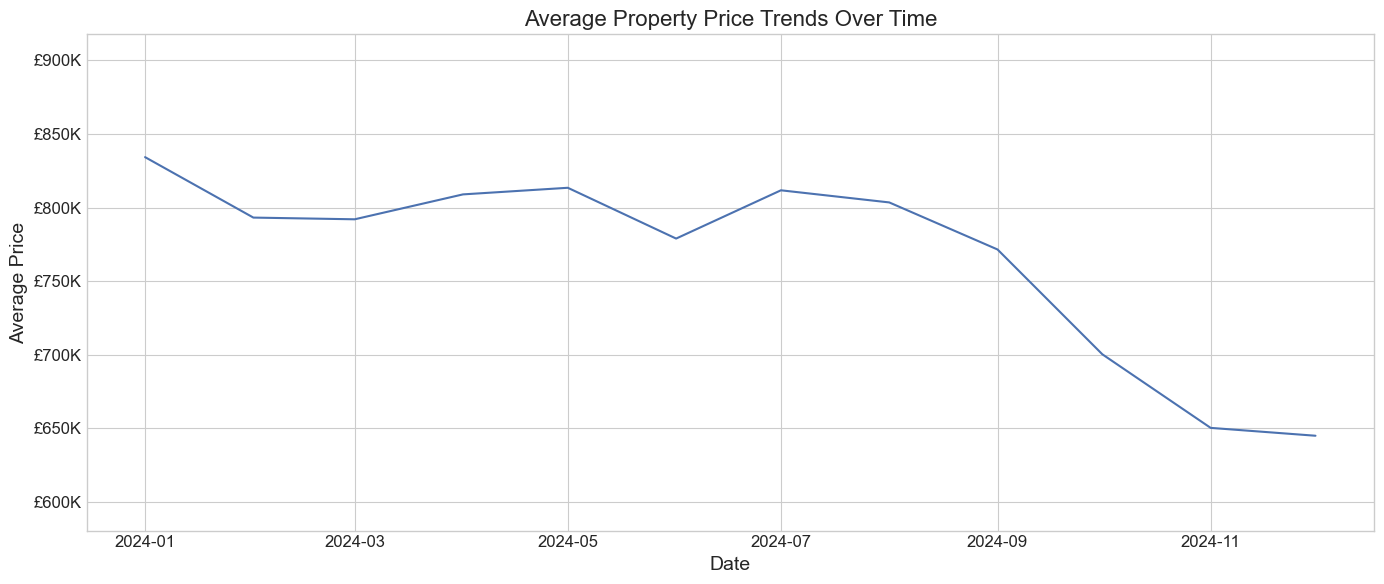

In [77]:
monthly_avg = df_clean.groupby(['year', 'month'])['price'].mean().reset_index()
monthly_avg['date'] = pd.to_datetime(monthly_avg[['year', 'month']].assign(day=1))

plt.figure(figsize=(14, 6))
plt.plot(monthly_avg['date'], monthly_avg['price'])
plt.title('Average Property Price Trends Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Price', fontsize=14)
ax = plt.gca()
ax.yaxis.set_major_formatter(formatter)

# Set a tighter y-axis range to make the trend more visible
min_price = monthly_avg['price'].min() * 0.9  # 10% below minimum for better visualization
max_price = monthly_avg['price'].max() * 1.1  # 10% above maximum for better visualization
plt.ylim(min_price, max_price)

plt.grid(True)
plt.tight_layout()
plt.savefig('C:/temp/price_trends.png', dpi=300)
plt.show()
plt.close()



## 12. Visualization 5: Property Type Price Comparison



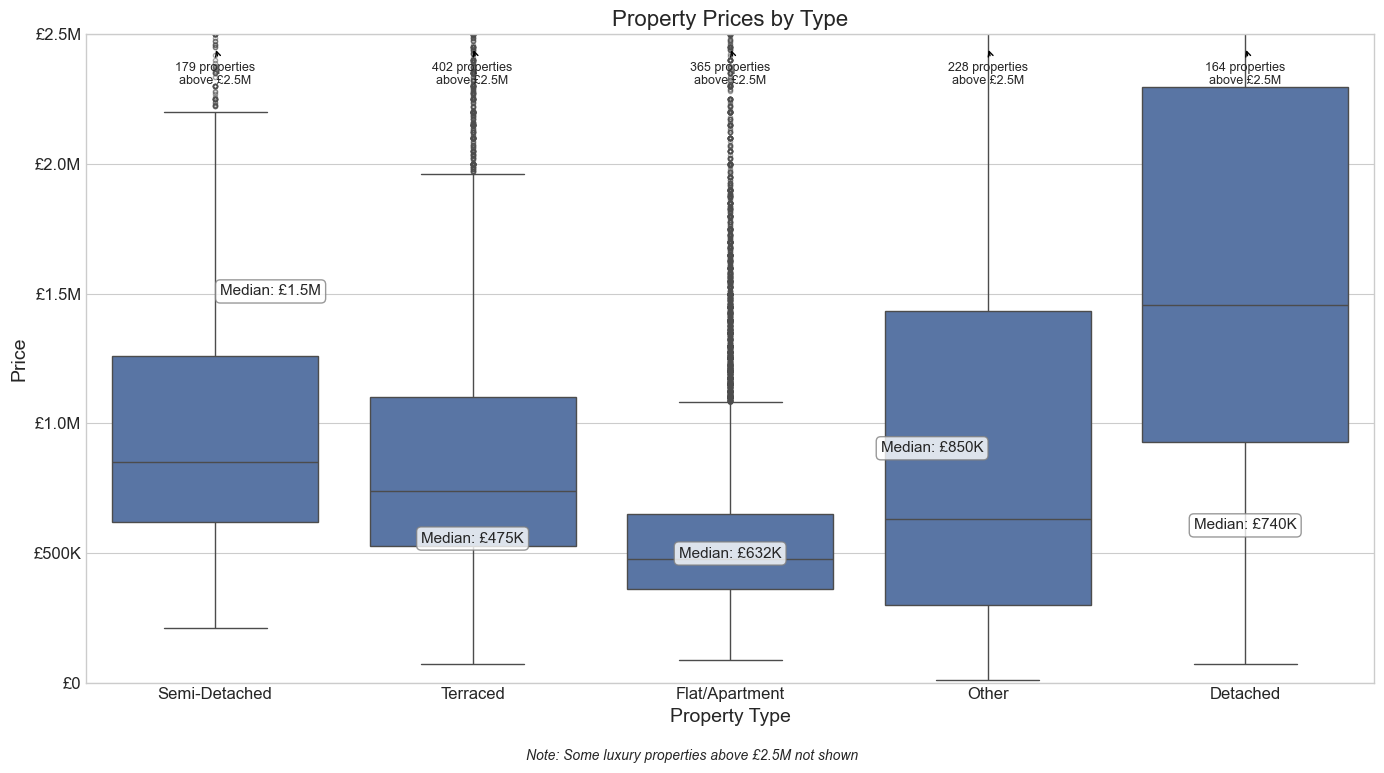

In [78]:
plt.figure(figsize=(14, 8))  # Increase height for better visibility
ax = sns.boxplot(x='property_type', y='price', data=df_clean, 
                 flierprops=dict(marker='o', markersize=3, alpha=0.5))  # Smaller outlier markers
plt.title('Property Prices by Type', fontsize=16)
plt.xlabel('Property Type', fontsize=14)
plt.ylabel('Price', fontsize=14)
ax.yaxis.set_major_formatter(formatter)
plt.ylim(0, 2500000)  # Limit y-axis to £2.5M

# Add footnote about outliers
plt.figtext(0.5, 0.01, "Note: Some luxury properties above £2.5M not shown", 
            fontsize=10, style='italic', ha='center')

# Add count of outliers above the limit for each property type
for i, prop_type in enumerate(df_clean['property_type'].unique()):
    outlier_count = len(df_clean[(df_clean['property_type'] == prop_type) & 
                                (df_clean['price'] > 2500000)])
    if outlier_count > 0:
        plt.annotate(f'{outlier_count} properties\nabove £2.5M', 
                    xy=(i, 2450000), 
                    xytext=(0, -10),
                    textcoords='offset points',
                    ha='center', va='top',
                    fontsize=9,
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

# Add median price for each property type with improved positioning
medians = df_clean.groupby('property_type')['price'].median()
for i, property_type in enumerate(medians.index):
    median_value = medians[property_type]
    # Position the label above or below the median line based on its position
    if property_type == 'Semi-Detached':
        xytext_offset = (-40, 10)  # Left and up for Semi-Detached
    elif property_type == 'Detached':
        xytext_offset = (40, 10)  # Right and up for Detached
    elif property_type == 'Terraced':
        xytext_offset = (0, -25)  # Down for Terraced
    elif property_type == 'Flat/Apartment':
        xytext_offset = (0, 15)  # Up for Flat/Apartment
    else:  # Other
        xytext_offset = (0, -25)  # Down for Other
        
    plt.annotate(f'Median: {pound_formatter(median_value, 0)}', 
                xy=(i, median_value), 
                xytext=xytext_offset,
                textcoords='offset points',
                ha='center', va='center',
                fontsize=11,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout to leave room for footnote
plt.savefig('C:/temp/price_by_property_type.png', dpi=300)
plt.show()
plt.close()



## 13. Visualization 6: Price Band Distribution



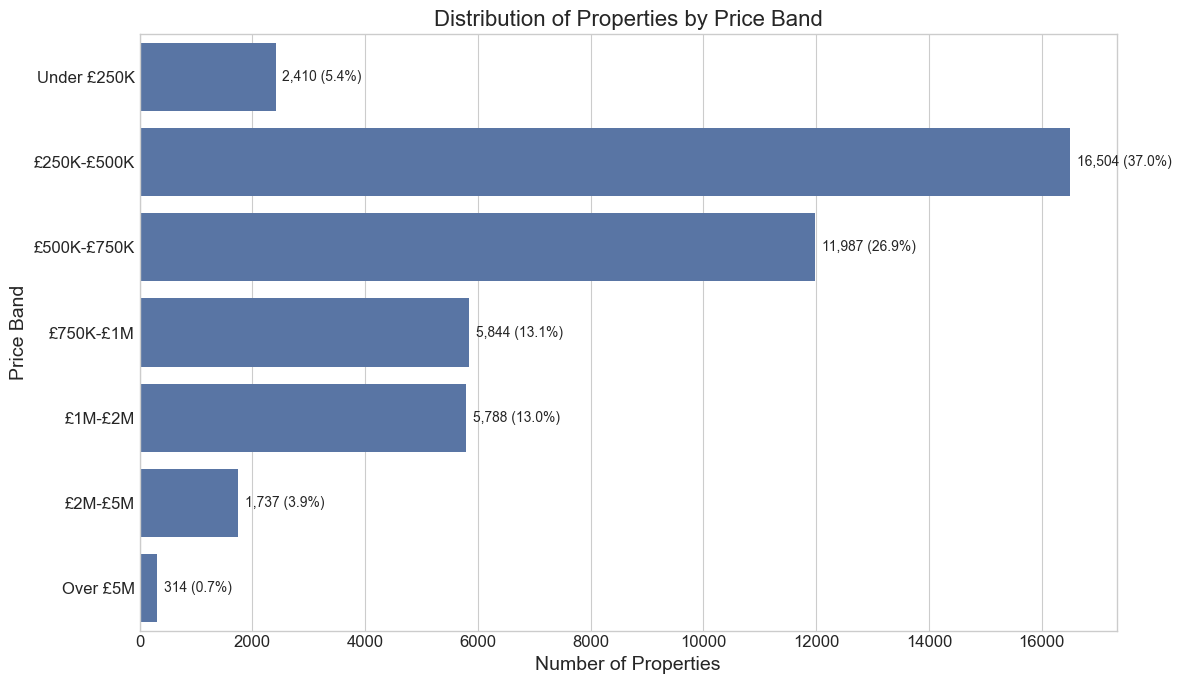

In [79]:
plt.figure(figsize=(12, 7))
ax = sns.countplot(y='price_band', data=df_clean, order=price_labels)
plt.title('Distribution of Properties by Price Band', fontsize=16)
plt.xlabel('Number of Properties', fontsize=14)
plt.ylabel('Price Band', fontsize=14)

# Add count and percentage labels to each bar
total = len(df_clean)
for i, p in enumerate(ax.patches):
    count = p.get_width()
    percentage = 100 * count / total
    ax.annotate(f'{count:,.0f} ({percentage:.1f}%)', 
                (p.get_width(), p.get_y() + p.get_height()/2),
                xytext=(5, 0),
                textcoords='offset points',
                ha='left', va='center',
                fontsize=10)

plt.tight_layout()
plt.savefig('C:/temp/price_band_distribution.png', dpi=300)
plt.show()
plt.close()



## 14. Visualization 7: Correlation Analysis



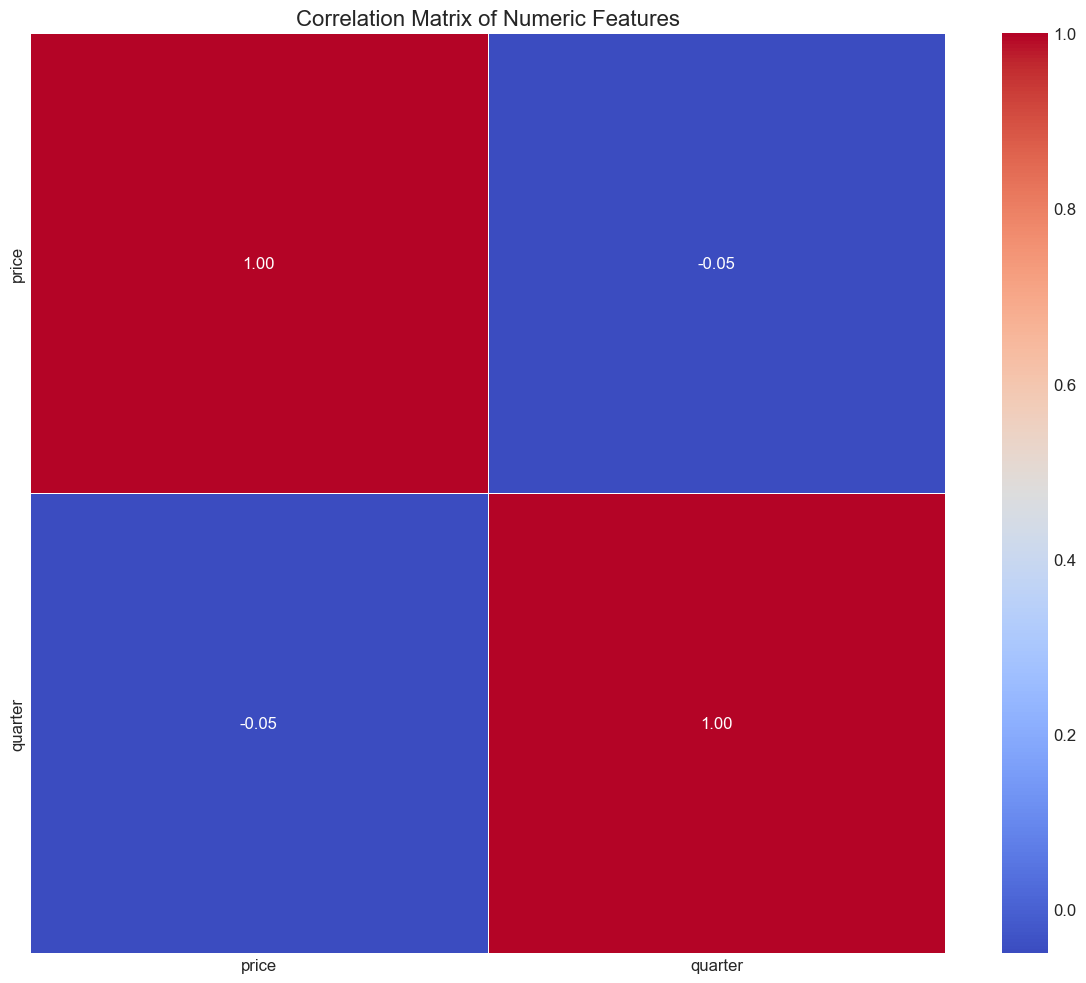

In [80]:
numeric_df = df_clean.select_dtypes(include=[np.number])
# Remove some columns that aren't meaningful for correlation
cols_to_drop = ['year', 'month']
numeric_df = numeric_df.drop(columns=[col for col in cols_to_drop if col in numeric_df.columns])
correlation = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.tight_layout()
plt.savefig('C:/temp/correlation_matrix.png', dpi=300)
plt.show()
plt.close()



## 15. Visualization 8: Price per Property Type by District



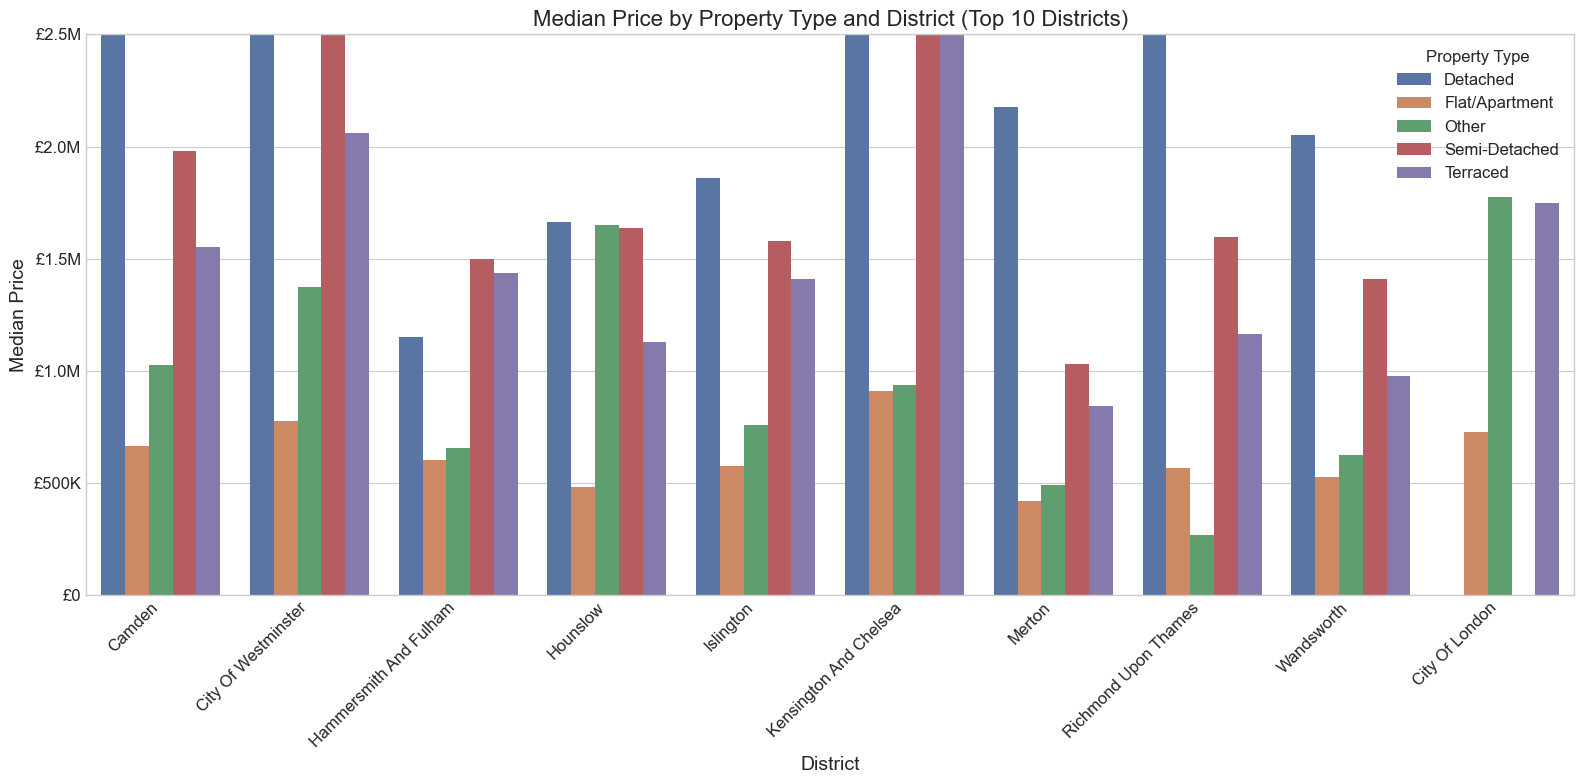

In [81]:
top_districts = district_prices.index[:10]  # Just use top 10 districts for clearer visualization
district_type_prices = df_clean[df_clean['district'].isin(top_districts)]
district_type_prices = district_type_prices.groupby(['district', 'property_type'])['price'].median().unstack().reset_index()
district_type_prices = district_type_prices.melt(id_vars=['district'], 
                                              var_name='property_type', 
                                              value_name='median_price')
district_type_prices = district_type_prices.dropna()

plt.figure(figsize=(16, 8))
ax = sns.barplot(x='district', y='median_price', hue='property_type', data=district_type_prices)
plt.title('Median Price by Property Type and District (Top 10 Districts)', fontsize=16)
plt.xlabel('District', fontsize=14)
plt.ylabel('Median Price', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.legend(title='Property Type', fontsize=12)
ax.yaxis.set_major_formatter(formatter)
plt.ylim(0, 2500000)  # Set a reasonable y-axis limit
plt.tight_layout()
plt.savefig('C:/temp/district_property_type_prices.png', dpi=300)
plt.show()
plt.close()



## 16. Visualization 9: Monthly Trends by Property Type



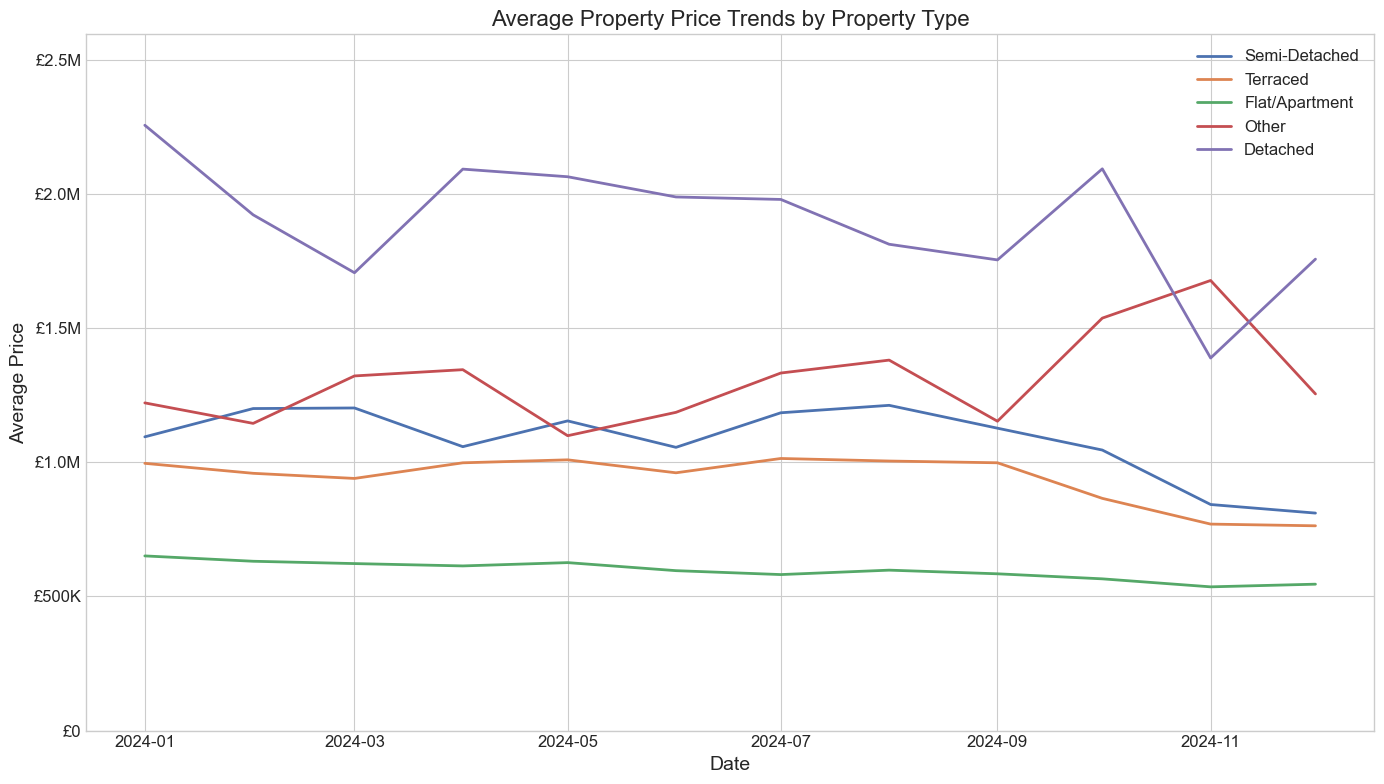

In [82]:
monthly_type_avg = df_clean.groupby(['year', 'month', 'property_type'])['price'].mean().reset_index()
monthly_type_avg['date'] = pd.to_datetime(monthly_type_avg[['year', 'month']].assign(day=1))

plt.figure(figsize=(14, 8))
for prop_type in df_clean['property_type'].unique():
    subset = monthly_type_avg[monthly_type_avg['property_type'] == prop_type]
    plt.plot(subset['date'], subset['price'], label=prop_type, linewidth=2)

plt.title('Average Property Price Trends by Property Type', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
ax = plt.gca()
ax.yaxis.set_major_formatter(formatter)

# Calculate the highest price plus some margin to ensure nothing is cut off
highest_price = monthly_type_avg['price'].max() * 1.15  # 15% above the maximum
lowest_price = 0  # Start from zero for better context
plt.ylim(lowest_price, highest_price)

plt.tight_layout()
plt.savefig('C:/temp/price_trends_by_type.png', dpi=300)
plt.show()
plt.close()



## 17. Visualization 10: Price Distribution by Property Type



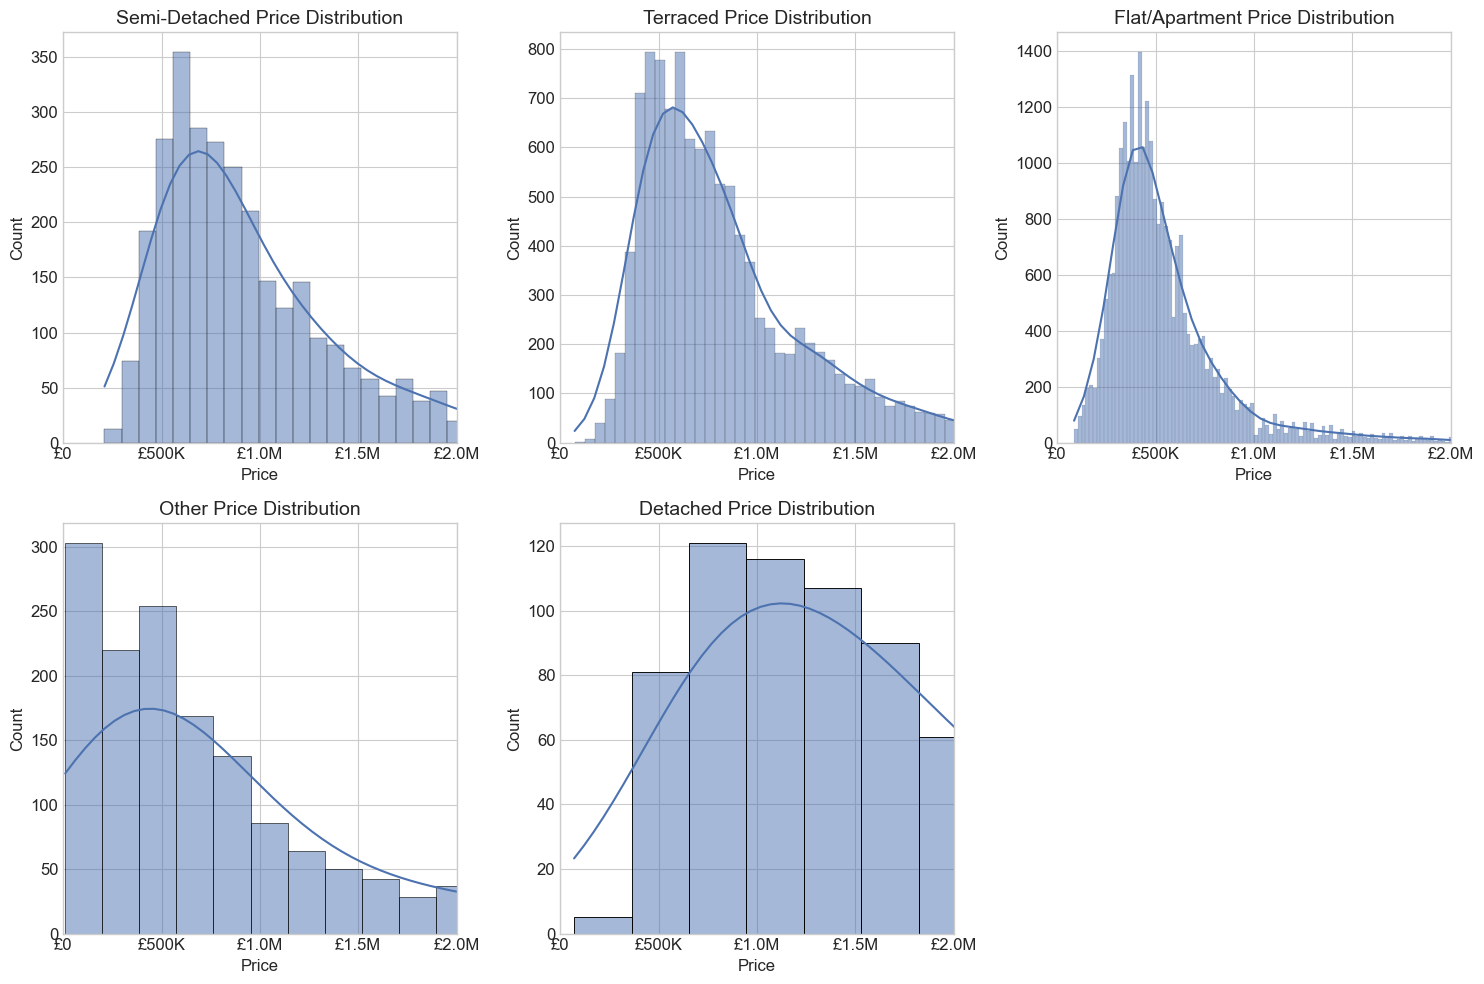

In [83]:
plt.figure(figsize=(15, 10))
for i, prop_type in enumerate(df_clean['property_type'].unique(), 1):
    plt.subplot(2, 3, i)
    subset = df_clean[df_clean['property_type'] == prop_type]['price']
    sns.histplot(subset, kde=True)
    plt.title(f'{prop_type} Price Distribution', fontsize=14)
    plt.xlabel('Price', fontsize=12)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(formatter)
    plt.xlim(0, 2000000)  # Consistent x-axis limit of £2M for all plots
    
plt.tight_layout()
plt.savefig('C:/temp/price_dist_by_type.png', dpi=300)
plt.show()
plt.close()




## 18. Statistical Testing



In [84]:
property_types = df_clean['property_type'].unique()
print("\nStatistical Testing: Property Type Price Comparisons\n")
print("ANOVA Test for Price Differences Between Property Types:")
property_type_groups = [df_clean[df_clean['property_type'] == pt]['price'] for pt in property_types]
f_stat, p_value = stats.f_oneway(*property_type_groups)
print(f"F-statistic: {f_stat:.2f}")
print(f"p-value: {p_value:.10f}")
if p_value < 0.05:
    print("There are statistically significant differences in prices between property types\n")
else:
    print("No statistically significant differences in prices between property types\n")

# Mann-Whitney U Test for comparing two specific districts
print("\nMann-Whitney U Test for Comparing District Prices:")

# First, let's see what districts are actually available in the data
available_districts = df_clean['district'].unique()
print(f"Number of districts in data: {len(available_districts)}")
print("Sample districts:", list(available_districts)[:5])  # Show first 5 as a sample

# Choose two districts that we know exist in the data
# For example, taking the most expensive and least expensive districts
most_expensive_district = all_districts.sort_values('median', ascending=False).index[0]
least_expensive_district = all_districts.sort_values('median').index[0]

print(f"\nComparing most expensive district ({most_expensive_district}) with least expensive ({least_expensive_district})")

# Extract price data for these districts
prices_district1 = df_clean[df_clean['district'] == most_expensive_district]['price']
prices_district2 = df_clean[df_clean['district'] == least_expensive_district]['price']

# Check data availability
print(f"Number of properties in {most_expensive_district}: {len(prices_district1)}")
print(f"Number of properties in {least_expensive_district}: {len(prices_district2)}")

# Perform the test if we have enough data
if len(prices_district1) > 0 and len(prices_district2) > 0:
    u_stat, p_value = stats.mannwhitneyu(prices_district1, prices_district2)
    print(f"Mann-Whitney U Test Results:")
    print(f"U-statistic: {u_stat}")
    print(f"p-value: {p_value:.10f}")
    if p_value < 0.05:
        print(f"There is a statistically significant difference in property prices between {most_expensive_district} and {least_expensive_district}")
    else:
        print(f"No statistically significant difference in property prices between {most_expensive_district} and {least_expensive_district}")
else:
    print("Insufficient data for one or both districts to perform the test")

# Let's also try with two districts that definitely have enough data
# Using the districts with the most properties
district_counts = df_clean['district'].value_counts()
top_district1 = district_counts.index[0]
top_district2 = district_counts.index[1]

print(f"\nAlternative comparison between districts with most properties: {top_district1} vs {top_district2}")

prices_top1 = df_clean[df_clean['district'] == top_district1]['price']
prices_top2 = df_clean[df_clean['district'] == top_district2]['price']

print(f"Number of properties in {top_district1}: {len(prices_top1)}")
print(f"Number of properties in {top_district2}: {len(prices_top2)}")

u_stat, p_value = stats.mannwhitneyu(prices_top1, prices_top2)
print(f"Mann-Whitney U Test Results:")
print(f"U-statistic: {u_stat}")
print(f"p-value: {p_value:.10f}")
if p_value < 0.05:
    print(f"There is a statistically significant difference in property prices between {top_district1} and {top_district2}")
else:
    print(f"No statistically significant difference in property prices between {top_district1} and {top_district2}")



Statistical Testing: Property Type Price Comparisons

ANOVA Test for Price Differences Between Property Types:
F-statistic: 1359.80
p-value: 0.0000000000
There are statistically significant differences in prices between property types


Mann-Whitney U Test for Comparing District Prices:
Number of districts in data: 30
Sample districts: ['Croydon', 'Richmond Upon Thames', 'Southwark', 'Wandsworth', 'Lambeth']

Comparing most expensive district (Kensington And Chelsea) with least expensive (Bexley)
Number of properties in Kensington And Chelsea: 1538
Number of properties in Bexley: 99
Mann-Whitney U Test Results:
U-statistic: 139015.0
p-value: 0.0000000000
There is a statistically significant difference in property prices between Kensington And Chelsea and Bexley

Alternative comparison between districts with most properties: Wandsworth vs Lambeth
Number of properties in Wandsworth: 4053
Number of properties in Lambeth: 3039
Mann-Whitney U Test Results:
U-statistic: 7423910.5
p-value: 0


## 19. Summary Report



In [85]:
# 19. Summary Report

# Recalculate district statistics to get all districts
all_districts = df_clean.groupby('district')['price'].agg(['mean', 'median', 'count'])

# Create a summary report
summary = {
    'Total Properties': len(df_clean),
    'Average Price': f"£{df_clean['price'].mean():,.2f}",
    'Median Price': f"£{df_clean['price'].median():,.2f}",
    'Price Range': f"£{df_clean['price'].min():,.2f} to £{df_clean['price'].max():,.2f}",
    'Most Common Property Type': df_clean['property_type'].value_counts().idxmax(),
    'Most Expensive District': all_districts.sort_values('median', ascending=False).index[0],
    'Least Expensive District': all_districts.sort_values('median').index[0],
    'Date Range': f"{df_clean['date_of_transfer'].min().strftime('%d %b %Y')} to {df_clean['date_of_transfer'].max().strftime('%d %b %Y')}",
    'Properties Above £1M': f"{(df_clean['price'] > 1000000).sum():,} ({(df_clean['price'] > 1000000).sum() / len(df_clean) * 100:.1f}%)"
}

print("\nLondon Property Market Analysis Summary:")
for key, value in summary.items():
    print(f"{key}: {value}")



London Property Market Analysis Summary:
Total Properties: 44584
Average Price: £775,687.04
Median Price: £560,000.00
Price Range: £10,000.00 to £10,000,000.00
Most Common Property Type: Flat/Apartment
Most Expensive District: Kensington And Chelsea
Least Expensive District: Bexley
Date Range: 01 Jan 2024 to 30 Dec 2024
Properties Above £1M: 7,839 (17.6%)
